Philippe Joly 2025-10-20

# Interim Report Plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft

## Interim Report Plasma Bin Graph

In [2]:
data_path = '/scratch/philj0ly/vis_plasma/average_plasma_bins_20_65536_1721343074_1721449881_64_183_v2.npz' 
with np.load(data_path) as f:
        avg_data = f["data"]
        missing_fraction = f["missing_fraction"]
        total_counts = f["total_counts"]
        bin_edges = f["bin_edges"]
        t_chunk = f["t_chunk"]
        chans = f["chans"]
        osamp = f["osamp"]

In [3]:
df_record = 125e6/2048
df = df_record/osamp

In [4]:
k_low, k_high = osamp*58, osamp*70
avg_subset = avg_data[:,:,:,:-osamp]
freqs_subset = chans[:-osamp]*df # chans[k_low:k_high]*df

Is = (avg_subset[:,0,0]+avg_subset[:,1,1]).real.astype("float32")
Is = np.log10(Is)

# for i in range(Is.shape[0]):
#     Is[i] -= np.median(Is[i])
# #     std = np.std(Is[i])
# #     # Is[i] = np.clip(Is[i], -2.0*std, 1*std)
#     Is[i] /= np.std(Is[i])*30
#     Is[i] -= np.nanmin(Is[i]) - 0.1
# Is = np.clip(Is, 0, 1)
# # for i in range(Is.shape[0]):
# #     Is[i] /= np.nanmax(Is[i])
# for isi in Is:
#     print(np.median(isi), np.std(isi))

Is -= np.median(Is[-1])
Is /= np.std(Is[-1])*30
Is -= np.nanmin(Is[-1]) - 0.1
Is = np.clip(Is, 0, 1)

/tmp/ipykernel_666771/3691871120.py:6: RuntimeWarning: divide by zero encountered in log10
  Is = np.log10(Is)


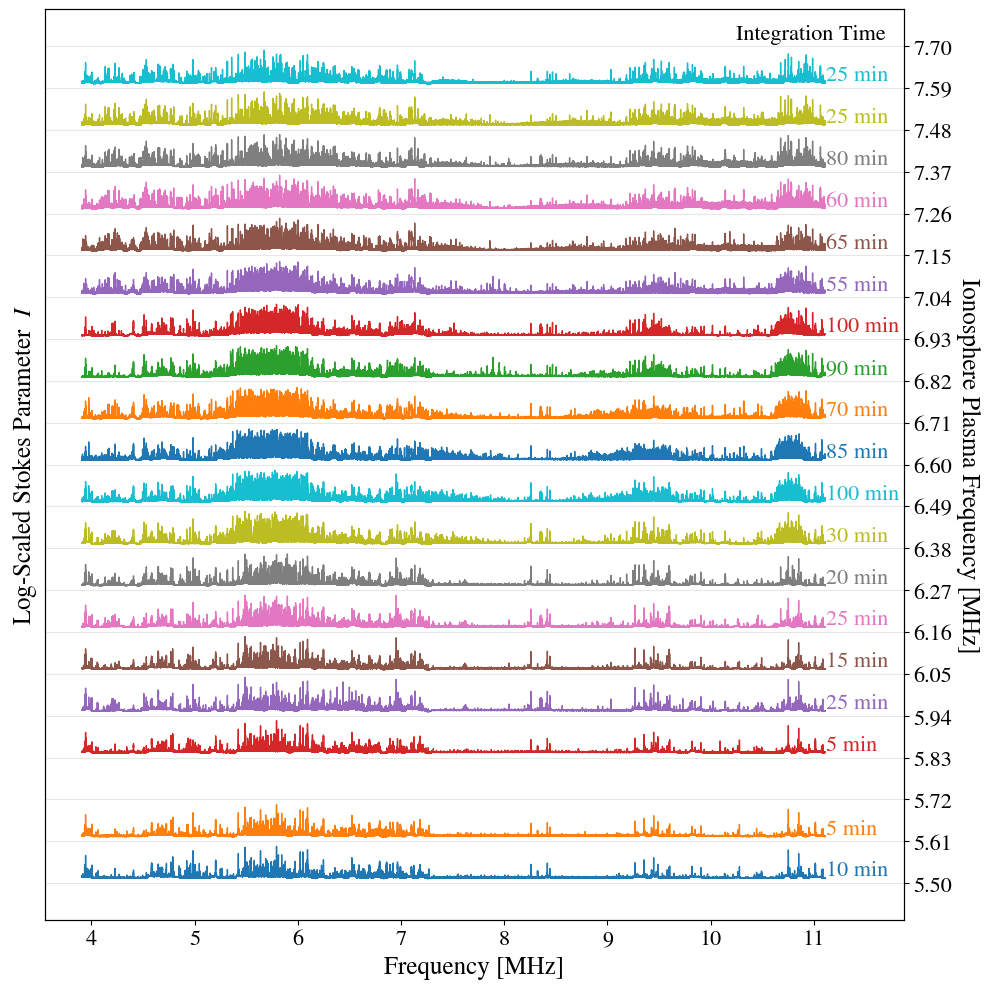

In [7]:
labels = [f"{total_counts[i] * t_chunk/60:.0f} min" for i in range(total_counts.shape[0])]
offset = 1  # vertical shift between stacked PSDs
cmap = plt.cm.tab10 


plt.figure(figsize=(10, 10))
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

# for i, label in enumerate(labels):
for i in range(20):
    label = labels[i]
    if total_counts[i] == 0:
        continue
    psd = Is[i]
    color = cmap(i%10)  # cycle through
    shifted = psd + i * offset
    plt.plot(freqs_subset/1e6, shifted, linewidth=1, color=color, )
    plt.text(freqs_subset[-1]/1e6 * 1.001,   
             (i+0.3) * offset,  
             label,
             fontsize=16,
             va='center',
             color=color)

plt.text(freqs_subset[-1]/1e6 * 0.922,   
             (20+0.3) * offset,  
             "Integration Time",
             fontsize=16,
             va='center',
             color='black')

plt.xlabel("Frequency [MHz]", fontsize=18)
plt.ylabel(r"Log-Scaled Stokes Parameter  $I$", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks([])
# plt.grid(axis='x', alpha=0.6)
xmin, xmax = plt.xlim()
plt.xlim(xmin, xmax * 1.035)

# Add right y-axis with bin edges
ax = plt.gca()
ax2 = ax.twinx()
# Position bin edges between PSDs (at i * offset for i = 0, 1, 2, ..., 20)
bin_positions = [i * offset for i in range(21)]
ax2.set_yticks(bin_positions)
ax2.set_yticklabels([f"{edge/1e6:.2f}" for edge in bin_edges], fontsize=16)
ax2.set_ylabel("Ionosphere Plasma Frequency [MHz]", fontsize=18, rotation=270, labelpad=20)
ax2.set_ylim(ax.get_ylim())  # Match the left axis limits

plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("interim_graph.png")
plt.show()

## Bin center Sine Test

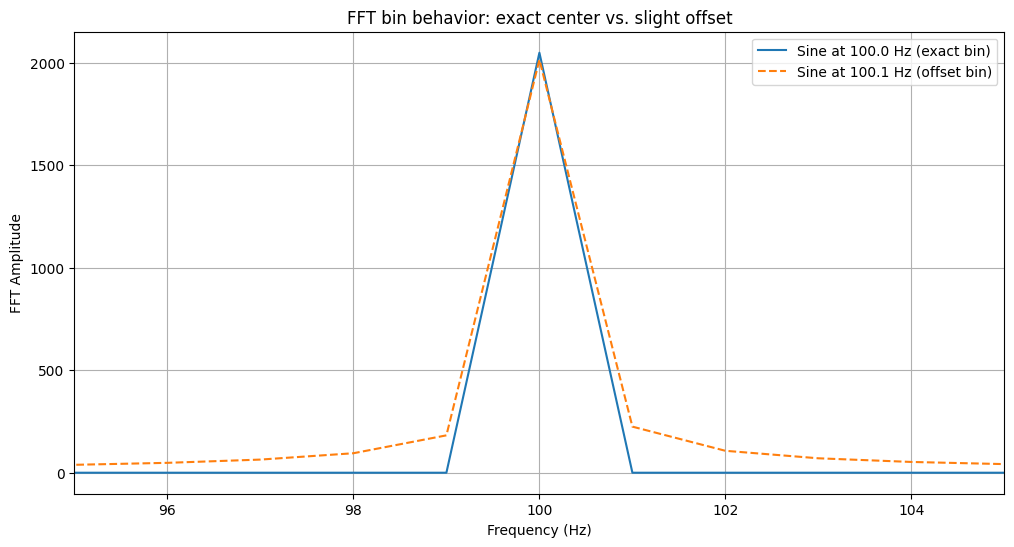

In [19]:
N = 4096             # FFT size
fs = 4096            # sampling rate (so bin spacing = 1 Hz)
bin_index = 100      # "channel number" Mohan is referring to
t = np.arange(N) / fs

# -----------------------
# Two test signals
# -----------------------
# Case 1: sine exactly at bin center --> f = 100.0 Hz
sig_center = np.sin(2*np.pi * (bin_index) * t)

# Case 2: sine slightly offset from bin --> f = 100.1 Hz
sig_offset = np.sin(2*np.pi * (bin_index + 0.1) * t)

# -----------------------
# FFTs
# -----------------------
fft_center = np.fft.fft(sig_center)
fft_offset = np.fft.fft(sig_offset)

# Compute amplitudes (magnitude)
amp_center = np.abs(fft_center)
amp_offset = np.abs(fft_offset)

# Frequency axis (for plotting only)
freqs = np.fft.fftfreq(N, 1/fs)

# -----------------------
# Plotting
# -----------------------
plt.figure(figsize=(12,6))

# Plot only positive freqs for clarity
pos_mask = freqs >= 0

plt.plot(freqs[pos_mask], amp_center[pos_mask], label="Sine at 100.0 Hz (exact bin)")
plt.plot(freqs[pos_mask], amp_offset[pos_mask], label="Sine at 100.1 Hz (offset bin)", linestyle='--')

plt.xlim(95, 105)  # zoom around the bin
plt.xlabel("Frequency (Hz)")
plt.ylabel("FFT Amplitude")
plt.title("FFT bin behavior: exact center vs. slight offset")
plt.legend()
plt.grid()
plt.show()

Only a tone at frequency k⋅Δf produces perfect constructive interference in bin k,
All other frequencies produce phase walk-off and leakage,

So, we conclude that bin center is straight on the channel Number!